In [1]:
%matplotlib inline

# Basic imports

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO

from matplotlib import pyplot as plt

from scipy import stats
from Bio.Alphabet.IUPAC import IUPACProtein

import glob
import sklearn.metrics

import datetime
year = datetime.date.today().year
month = datetime.date.today().month

import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True


# Functions for parsing couplings and contacts dataframes

In [4]:
from supporting_functions import *

# Single example

In [ ]:
contact_number_modifier = 1
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']
df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = []
SC_distance_cutoffs = []

prot_name = '1AOE_A'
couplings_file = '../Data/Empirical_couplings/{}_rp75.plmc.processed.couplings'.format(prot_name)

print('###', prot_name)
total_contacts = 0
cutoff=0
for metric in metrics:            
    df_couplings = pd.read_csv(couplings_file, sep=',')
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        print(couplings_file)
        continue
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
    records = list(SeqIO.parse('../Data/fastas/{}.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
    number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
    if metric == 'CA':
        total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=CA_distance_cutoff)
        print(metric, ppv, total_contacts)
    else:
        temp = df_contacts_stack.sort_values('distance')[:total_contacts]
        cutoff = temp.iloc[total_contacts-1]['distance']
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
        print(metric, ppv, len(temp.index), cutoff)
        if metric == 'CB':
            CB_distance_cutoffs.append(cutoff)
        elif metric == 'SCcenter':
            SC_distance_cutoffs.append(cutoff)

    if metric == 'CA':
        lengths.append(len(df_contacts.columns))
    df_contacts_dict[metric][prot_name] = df_contacts_stack

# Iterating through all available
**This will take a few minutes to run**

In [82]:
contact_number_modifier = 0.5
chain_cutoff = 12
# metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
# metrics = ['CA', 'all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others
metrics = ['CA', 'CB', 'SCcenter', 'all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others
df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = {}
SC_distance_cutoffs = {}

# for couplings_file in glob.glob('../Data/Empirical_couplings/*.plmc.processed.couplings')[:]:
# for couplings_file in glob.glob('../Data/Empirical_couplings/*.psicov.processed.couplings')[:]:
for couplings_file in glob.glob('../Data/Empirical_couplings/*.ccmpred.processed.couplings')[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
#     alignment_file = alignment_file.replace('.plmc.processed.couplings', '.mafft.processed.afa')
#     alignment_file = alignment_file.replace('.psicov.processed.couplings', '.mafft.processed.afa')
    alignment_file = alignment_file.replace('.ccmpred.processed.couplings', '.mafft.processed.afa')
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)
#     if nseqs > 1000:
#         continue
#     db_name = couplings_file.split('/')[-1].split('_')[2].strip('.couplings')
#     nseqs = hmmer_results_dict[db_name][hmmer_results_dict[db_name][1]==prot_name].iloc[0][2]
#     if prot_name in df_contacts_dict[metrics[0]]:
#         continue
#     if nseqs < 2000:
#         continue
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, 12)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, 12)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
        if metric == 'CA':
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
            cutoff = CA_distance_cutoff
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
        else:
            temp = df_contacts_stack.sort_values('distance')[:total_contacts]
            cutoff = temp.iloc[total_contacts-1]['distance']
            print(metric, cutoff)
            if metric == 'CB':
                CB_distance_cutoffs[prot_name] = cutoff
            elif metric == 'SCcenter':
                SC_distance_cutoffs[prot_name] = cutoff

        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
#         print(metric, ppv, len(temp.index), cutoff)
#         merged_df['contact'] = np.where(merged_df['distance']>=CA_distance_cutoff, 0, 1)
#         aupr = sklearn.metrics.average_precision_score(merged_df['contact'], merged_df['couplings'])
#         print(aupr)
        ppv_dict[metric].append(ppv)
        df_contacts_dict[metric][prot_name] = df_contacts_stack

### 5PTP_A (9964)
CB 7.61645174026
SCcenter 7.62887573242
all_atoms_min 4.60785806968
sc_atoms_min 6.262028746
### 1VFY_A (4623)
CB 7.65992736816
SCcenter 7.4942908287
all_atoms_min 4.44112745375
sc_atoms_min 5.96543874368
### 1I71_A (3484)
CB 7.8727440834
SCcenter 8.00643348694
all_atoms_min 4.62446809601
sc_atoms_min 6.35249588281
### 1DQG_A (346)
CB 7.80859899521
SCcenter 7.80222082138
all_atoms_min 4.46669763729
sc_atoms_min 6.19703130431
### 1FNA_A (7886)
CB 7.94077777863
SCcenter 8.16356277466
all_atoms_min 4.60673857176
sc_atoms_min 6.67622178642
### 1HXN_A (782)
CB 7.7442035675
SCcenter 7.59127902985
all_atoms_min 4.64605907092
sc_atoms_min 6.09935723759
### 1XKR_A (3503)
CB 7.4662528038
SCcenter 7.16535234451
all_atoms_min 4.37829378913
sc_atoms_min 5.60303512752
### 1C52_A (3794)
CB 7.45111465454
SCcenter 7.28978395462
all_atoms_min 4.27696083239
sc_atoms_min 5.54805960432
### 2MHR_A (1062)
CB 6.83340740204
SCcenter 5.81425237656
all_atoms_min 3.81147147123
sc_atoms_min 4.040

# Visualizing diffs

In [87]:
len(lengths)

150

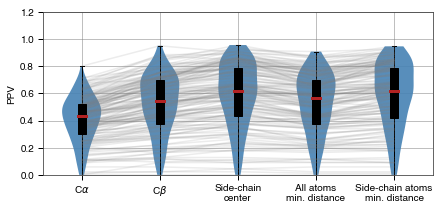

In [90]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([ppv_dict[metric] for metric in metrics], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('')
    pc.set_alpha(0.9)

bplot = ax.boxplot([ppv_dict[metric] for metric in metrics], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
    
for i in range(len(lengths)):
#     ax.plot([1,2,3], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i]],\
#             color='gray', alpha=0.15)
    ax.plot([1,2,3,4,5], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i],\
                     ppv_dict['all_atoms_min'][i], ppv_dict['sc_atoms_min'][i]],\
            color='gray', alpha=0.15)
    
# ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter'])
ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter',\
                   'All atoms\nmin. distance', 'Side-chain atoms\nmin. distance'])

ax.set_ylim(0, 1.2)
ax.set_ylabel('PPV')
# plt.savefig('{}/empirical_boxplots.pdf'.format(figs_dir), bbox_inches='tight')
plt.savefig('{}/empirical_boxplots_large.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_psicov.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_plmc.pdf'.format(figs_dir), bbox_inches='tight')

**A little bit of exploring**

In [95]:
stats.wilcoxon(ppv_dict['all_atoms_min'], ppv_dict['sc_atoms_min'])

WilcoxonResult(statistic=142.0, pvalue=1.5289782991510069e-22)

In [91]:
for metric in metrics:
    print(metric, np.median(ppv_dict[metric]))

CA 0.432908545727
CB 0.544879171461
SCcenter 0.620833333333
all_atoms_min 0.562192874693
sc_atoms_min 0.618347338936


In [28]:
print(0.620833333333/0.432908545727)
print(0.620833333333/0.544879171461)
print(np.nanmedian(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CB'])))
print(np.nanmedian(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CA'])))

1.434098124097806
1.1393963393174709
1.125
1.42857142857


/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [13]:
# print(stats.wilcoxon(ppv_dict['CB'], ppv_dict['all_atoms_min']))

In [15]:
# print(stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter']))
print(stats.wilcoxon(ppv_dict['CA'], ppv_dict['CB']))
print(stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter']))
print(stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter']))
print(len(ppv_dict['CB']))

WilcoxonResult(statistic=33.5, pvalue=1.4192899608688949e-25)
WilcoxonResult(statistic=162.5, pvalue=7.0955768907230847e-23)
WilcoxonResult(statistic=2.0, pvalue=1.5891343633625493e-25)
150


/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encounter

#################
CA vs SC center
150 nan
WilcoxonResult(statistic=35.5, pvalue=2.1687984892843284e-25)
#################
CB vs SC center
150 nan
WilcoxonResult(statistic=340.0, pvalue=1.018054369905109e-20)


/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in true_divide


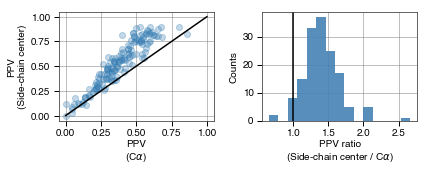

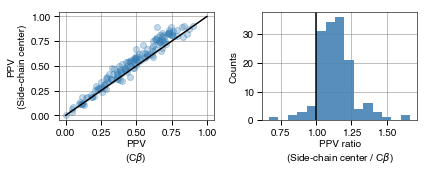

In [81]:
loglog=False

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
if not loglog:
    ax_arr[0].plot(ppv_dict['CA'], ppv_dict['SCcenter'], marker='o',\
                   markerfacecolor='steelblue', linestyle='', alpha=0.3)
    ax_arr[0].plot([0,1], [0,1], 'k-')
else:
    ax_arr[0].loglog(ppv_dict['CA'], ppv_dict['SCcenter'], marker='o')
    ax_arr[0].loglog([0.1,1], [0.1,1], 'k-')
ax_arr[0].set_xlabel(r'PPV''\n'r'(C$\alpha$)')
ax_arr[0].set_ylabel(r'PPV''\n'r'(Side-chain center)')


deltas = np.array(ppv_dict['SCcenter']) / np.array(ppv_dict['CA'])
deltas = deltas[~np.isnan(deltas)]
deltas = deltas[~np.isinf(deltas)]
ax_arr[1].hist(deltas, 15, facecolor='steelblue', alpha=0.9, normed=False)
ax_arr[1].axvline(1, color='k')
ax_arr[1].set_xlabel(r'PPV ratio''\n'r'(Side-chain center / C$\alpha$)')
ax_arr[1].set_ylabel('Counts')
plt.tight_layout()
print('#################')
print('CA vs SC center')
print(len(ppv_dict['CA']), np.median(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CA'])))
print(stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter']))

# plt.savefig('{}/sc_vs_ca_empirical.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/sc_vs_ca_empirical_psicov.pdf'.format(figs_dir), bbox_inches='tight')
plt.savefig('{}/sc_vs_ca_empirical_plmc.pdf'.format(figs_dir), bbox_inches='tight')



fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
if not loglog:
    ax_arr[0].plot(ppv_dict['CB'], ppv_dict['SCcenter'], marker='o',\
                   markerfacecolor='steelblue', linestyle='', alpha=0.3)
    ax_arr[0].plot([0,1], [0,1], 'k-')
else:
    ax_arr[0].loglog(ppv_dict['CB'], ppv_dict['SCcenter'], 'bo')
    ax_arr[0].loglog([0.05,0.8], [0.05,0.8], 'k-')
ax_arr[0].set_xlabel(r'PPV''\n'r'(C$\beta$)')
ax_arr[0].set_ylabel(r'PPV''\n'r'(Side-chain center)')

deltas = np.array(ppv_dict['SCcenter']) / np.array(ppv_dict['CB'])
deltas = deltas[~np.isnan(deltas)]
deltas = deltas[~np.isinf(deltas)]
ax_arr[1].hist(deltas, 15, facecolor='steelblue', alpha=0.9, normed=False)
ax_arr[1].axvline(1, color='k')
ax_arr[1].set_xlabel(r'PPV ratio''\n'r'(Side-chain center / C$\beta$)')
ax_arr[1].set_ylabel('Counts')
plt.tight_layout()
print('#################')
print('CB vs SC center')
print(len(ppv_dict['CB']), np.median(np.array(ppv_dict['SCcenter'])/np.array(ppv_dict['CB'])))
print(stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter']))

# plt.savefig('{}/sc_vs_cb_empirical.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/sc_vs_cb_empirical_psicov.pdf'.format(figs_dir), bbox_inches='tight')
plt.savefig('{}/sc_vs_cb_empirical_plmc.pdf'.format(figs_dir), bbox_inches='tight')

**Some SI figs**

SpearmanrResult(correlation=0.66913973362933099, pvalue=8.0393006038592765e-21)
SpearmanrResult(correlation=0.68084270391321522, pvalue=9.2277633798325938e-22)


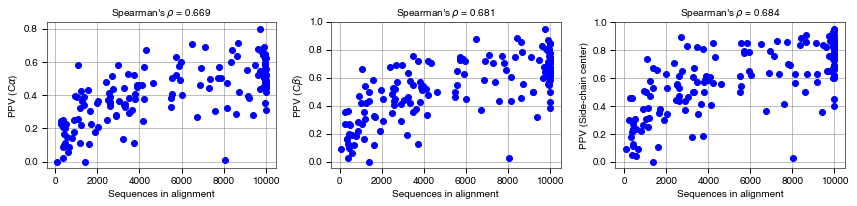

In [51]:
metric = 'CA'
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
ax_arr[0].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[0].set_xlabel('Sequences in alignment')
ax_arr[0].set_ylabel('PPV ({})'.format(r'C$\alpha$'))
ax_arr[0].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
metric = 'CB'
ax_arr[1].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[1].set_xlabel('Sequences in alignment')
ax_arr[1].set_ylabel('PPV ({})'.format(r'C$\beta$'))
ax_arr[1].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
metric = 'SCcenter'
ax_arr[2].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[2].set_xlabel('Sequences in alignment')
ax_arr[2].set_ylabel('PPV ({})'.format(r'Side-chain center'))
ax_arr[2].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
plt.tight_layout()
plt.savefig('{}/length_correlations.pdf'.format(figs_dir), bbox_inches='tight')

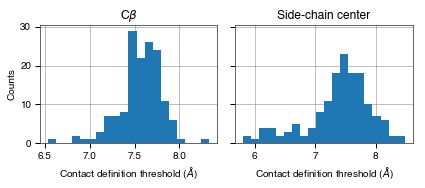

In [73]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,2.7))
ax_arr[0].hist(list(CB_distance_cutoffs.values()), 20);
ax_arr[1].hist(list(SC_distance_cutoffs.values()), 20);
ax_arr[0].set_ylabel('Counts')

ax_arr[0].set_xlabel(r'Contact definition threshold ($\AA$)')
ax_arr[1].set_xlabel(r'Contact definition threshold ($\AA$)')
ax_arr[0].set_title(r'C$\beta$', fontsize=12)
ax_arr[1].set_title(r'Side-chain center', fontsize=12)
plt.tight_layout()
plt.savefig('{}/contact_thresholds.pdf'.format(figs_dir), bbox_inches='tight')
# ax.set_xlim(0, 20)
# ax.axvline(7, color='k')

# Comparing angles

In [ ]:
from collections import defaultdict

In [ ]:
contact_number_modifier_list = [2, 1, 0.5, 0.25]
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']

angles_ppv_dict = {}
for angle in ['both', 'one', 'none']:
    angles_ppv_dict[angle] = []

CA_distance_cutoff = 8
results_dict = defaultdict(list)
done = []

for couplings_file in glob.glob('../Data/Empirical_couplings/*.ccmpred.processed.couplings')[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.ccmpred.processed.couplings', '.mafft.processed.afa')
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)    
#     if nseqs < 1000:
#         continue
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print("no contacts file found:", couplings_file)
            continue


        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        df_angles = pd.read_csv('../Data/Contact_matrices/{}_CA_angles.csv'.format(prot_name), index_col=0)
        df_angles.columns = df_angles.columns.astype(int)
        df_angles_stack = process_angles_df(df_angles, chain_cutoff)
        df_angles_stack['classification'] = 'none'
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) & ~(df_angles_stack['angles2'] < np.pi/2), 'one', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) | ~(df_angles_stack['angles2'] < np.pi/2), 'both', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'].isnull()), np.nan, inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles2'].isnull()), np.nan, inplace=True)

        merged_df = pd.concat([merged_df, df_angles_stack[['angles1', 'angles2', 'classification']]],\
                              axis=1, join_axes=[merged_df.index])

        if metric == 'CA':
            temp = merged_df[merged_df['distance'] < CA_distance_cutoff]['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))
#             results_dict[metric].append((temp['both']+temp['one'])/sum(temp))


            temp = merged_df['classification'].value_counts()
            results_dict['All'].append(temp['both']/sum(temp))
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
    
            for contact_number_modifier in contact_number_modifier_list:
                number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
                temp_df = merged_df[:number_to_test]

                temp = temp_df['classification'].value_counts()
                if 'both' in temp.keys():
                    results_dict['Couplings_{}'.format(contact_number_modifier)].append(temp['both']/sum(temp))
                else:
                    results_dict['Couplings_{}'.format(contact_number_modifier)].append(0)

        else:
            temp = merged_df.sort_values('distance')[:total_contacts]
            temp = temp['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))
#             results_dict[metric].append((temp['both']+temp['one'])/sum(temp))
        done.append(prot_name)

In [ ]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
labels = ['Top 0.25L', 'Top 0.5L', 'Top L', 'Top 2L', 'Side-chain',\
          r'C$\beta$', r'C$\alpha$', 'All pairs']
bplot = ax.boxplot([results_dict['All'], results_dict['CA'], results_dict['CB'], results_dict['SCcenter'],\
           results_dict['Couplings_2'], results_dict['Couplings_1'], results_dict['Couplings_0.5'],\
           results_dict['Couplings_0.25']][::-1],\
           labels = labels, vert=False, patch_artist=True);

for patch in bplot['boxes']:
    patch.set_facecolor('white')
# ax.axhline(4.5, c='k')
# ax.axhline(7.5, c='k')
ax.axhspan(7.5, 8.5, alpha=0.3, color='k')
ax.axhspan(4.5, 7.5, alpha=0.35, color='C4')
ax.axhspan(0, 4.5, alpha=0.35, color='C8')

ax.set_xlabel('Fraction of residue-residue\npairs with side-chains pointing\ntowards one-another')

plt.savefig('{}/Side_chain_success.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
contact_number_modifier_list = [2, 1, 0.5, 0.25]
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']

CA_distance_cutoff = 8

couplings_file = '../Data/Empirical_couplings/1AOE_A_rp75.ccmpred.processed.couplings'
prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
alignment_file = alignment_file.replace('.ccmpred.processed.couplings', '.mafft.processed.afa')
alignments = list(SeqIO.parse(alignment_file, 'fasta'))
nseqs = len(alignments)    

total_contacts = 0
cutoff=0

results_dict = {}

for metric in metrics:
    df_couplings = pd.read_csv(couplings_file, sep=',')
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        print("no contacts file found:", couplings_file)
        continue


    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
    records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


    df_angles = pd.read_csv('../Data/Contact_matrices/{}_CA_angles.csv'.format(prot_name), index_col=0)
    df_angles.columns = df_angles.columns.astype(int)
    df_angles_stack = process_angles_df(df_angles, chain_cutoff)
    df_angles_stack['classification'] = 'none'
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) & ~(df_angles_stack['angles2'] < np.pi/2), 'one', inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) | ~(df_angles_stack['angles2'] < np.pi/2), 'both', inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'].isnull()), np.nan, inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles2'].isnull()), np.nan, inplace=True)

    merged_df = pd.concat([merged_df, df_angles_stack[['angles1', 'angles2', 'classification']]],\
                          axis=1, join_axes=[merged_df.index])

    if metric == 'CA':
        temp = merged_df[merged_df['distance'] < CA_distance_cutoff]['classification'].value_counts()
        results_dict[metric] = (temp['both'], temp['one'], temp['none'])
        total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
        temp2 = merged_df['classification'].value_counts()
        results_dict['All'] = (temp2['both'], temp2['one'], temp2['none'])

    else:
        temp = merged_df.sort_values('distance')[:total_contacts]
        temp = temp['classification'].value_counts()
        results_dict[metric] = (temp['both'], temp['one'], temp['none'])

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['i.', 'ii.', 'iii.']
sizes = results_dict['CA']

fig1, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(4.5,1.5))
patches, texts = ax_arr[0].pie(sizes, startangle=90)
ax_arr[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

sizes = results_dict['CB']
patches, texts = ax_arr[1].pie(sizes, startangle=90)
ax_arr[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


sizes = results_dict['SCcenter']
patches, texts = ax_arr[2].pie(sizes, startangle=90)
ax_arr[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

legend = ax_arr[1].legend(patches, labels, ncol=3, bbox_to_anchor=(0.8, -0.05, 1., .102), fontsize=12, title='Contact type')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

textstr1 = r'C$\alpha$'
props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[0].text(0.05, 0.55, textstr1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

textstr2 = r'C$\beta$'

props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[1].text(0.51, 0.55, textstr2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# plt.tight_layout()

textstr3 = 'Side-chain'
props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[1].text(0.87, 0.55, textstr3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# plt.tight_layout()

plt.savefig('{}/Side_chain_pie.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
results_dict['CA']